In [1]:
import cv2
import numpy as np
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
import os as os

In [42]:
def preprocess_image(image):
    frame = cv2.resize(image, (640, 640))
    p1 = (50, 55)
    p2 = (60, 595)
    p3 = (555, 30)
    p4 = (605, 565)
    
    # Points to be transformed
    pts1 = np.float32([p1, p2, p3, p4])
    pts2 = np.float32([[0, 0], [0, 640], [640, 0], [640, 640]])
    matrix = cv2.getPerspectiveTransform(pts1, pts2)
    transformed_img = cv2.warpPerspective(frame, matrix, (640, 640))
    
    # Convert to grayscale and apply Gaussian blur
    gray = cv2.cvtColor(transformed_img, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    return blurred

def detect_chessboard(image):
    # Use adaptive thresholding to find the chessboard grid
    thresh = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Find the largest square contour (assumed to be the chessboard)
    chessboard_contour = max(contours, key=cv2.contourArea)
    return chessboard_contour

def extract_chessboard(image, contour):
    # Get the bounding rectangle of the chessboard
    x, y, w, h = cv2.boundingRect(contour)
    chessboard = image[y:y+h, x:x+w]
    return chessboard

def segment_board(chessboard):
    # Divide the chessboard into 64 squares
    height, width = chessboard.shape
    square_h, square_w = height // 8, width // 8
    squares = []
    for i in range(8):
        for j in range(8):
            square = chessboard[i*square_h:(i+1)*square_h, j*square_w:(j+1)*square_w]
            squares.append(square)
    return squares

def compare_squares(square1, square2):
    # Compare squares using Structural Similarity Index (SSIM)
    return ssim(square1, square2)


In [82]:
def coordinate_to_chess_notation(row, col):
    # white at top
    columns = 'hgfedcba'
    # for white at bottom
    # columns = 'abcdefgh'
    # black  at bottom
    return f"{columns[col]}{row}"

In [94]:
def detect_changes(image1, image2, threshold=0.81):
    # Preprocess images
    prep1 = preprocess_image(image1)
    prep2 = preprocess_image(image2)
    
    # The entire preprocessed image is now the chessboard
    board1 = prep1
    board2 = prep2
    
    # Segment boards into squares
    squares1 = segment_board(board1)
    squares2 = segment_board(board2)
    
    # Compare corresponding squares
    changes = []
    for i in range(64):
        similarity = compare_squares(squares1[i], squares2[i])
        if similarity < threshold:
            row, col = i // 8, i % 8
            changes.append(coordinate_to_chess_notation(row, col))
    plt.imshow(prep1)
    # plt.imshow(prep2)

    return bool(changes), changes

Detected changes at squares: (True, ['c5', 'b5', 'd6'])


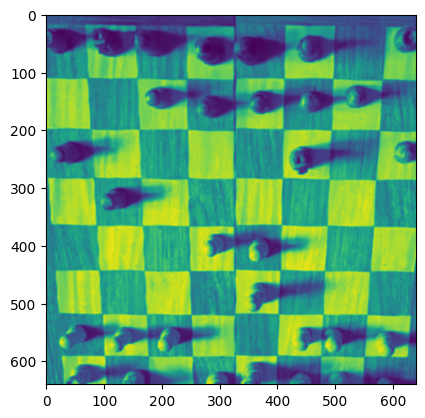

In [95]:
# Example usage
image1 = cv2.imread('pics2R/frame_0131.jpg')
image2 = cv2.imread('pics2R/frame_0132.jpg')
changes = detect_changes(image1, image2)
print(f"Detected changes at squares: {changes}")


In [87]:
# not rotated
# Detected changes at squares: (True, ['c6', 'd6', 'b5', 'c5'])

# not rotated changed coordinates
# Detected changes at squares: (True, ['f3', 'e3', 'g4', 'f4'])

# rotated